In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import plot_roc_curve, confusion_matrix, plot_confusion_matrix, plot_precision_recall_curve
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [19]:
def standard_scaler(data):
    mean = data.mean(axis=0)
    std = data.std(axis=0)
    norm = lambda x: (x - mean) / std
    inv_norm = lambda norm_x: norm_x * std + mean
    return norm(data), norm, inv_norm

def accuracy_score(y_true, y_predict):
    return np.sum(y_true == y_predict) / len(y_true)

def recall_score(y_true, y_predict):
    n_true_positives = np.count_nonzero((y_true == 1) & (y_predict == 1))
    n_false_negatives = np.count_nonzero((y_true == 1) & (y_predict == 0))
    return n_true_positives / (n_true_positives + n_false_negatives)

def precision_score(y_true, y_predict):
    n_true_positives = np.count_nonzero((y_true == 1) & (y_predict == 1))
    n_false_positives = np.count_nonzero((y_true == 0) & (y_predict == 1))
    return n_true_positives / (n_true_positives + n_false_positives)

def f1_score(y_true, y_predict):
    recall = recall_score(y_true, y_predict)
    precision = precision_score(y_true, y_predict)
    return 2 * (recall * precision) / (recall + precision)

def print_model_scores(model, x_test, y_test):
    y_predict = model.predict(x_test).ravel()
    y_test = y_test.ravel()
    # Make sure both have the same format
    print(f'Accuracy: {accuracy_score(y_predict, y_test)}')
    print(f'Precision: {precision_score(y_predict, y_test)}')
    print(f'Recall: {recall_score(y_predict, y_test)}')
    print(f'F1-Score: {f1_score(y_predict, y_test)}')

## Boston Dataset

In [3]:
boston = np.genfromtxt('./bostonbin.csv', delimiter=',')
X, Y = boston[:, :-1], boston[:, [-1]]

In [4]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=.2)
x_train.shape, y_train.shape

((404, 17), (404, 1))

## Definição do espaço de busca

In [6]:
svm_search_params = {
    'svc__C': [2**i for i in range(-5, 16)],
    'svc__gamma': [2**i for i in range(-15, 4)],
    'svc__kernel': ['rbf']
}

rfc_search_params = {
    'randomforestclassifier__n_estimators': [10 * i for i in range(1, 21)],
    'randomforestclassifier__max_depth': [2, 4, 8, None]
}

In [7]:
svm_pipeline = make_pipeline(
    StandardScaler(),
    SVC()
)

## SVC - Suport Vector Classifier

In [12]:
svm_grid = GridSearchCV(svm_pipeline, svm_search_params, cv=10, refit=True)
svm_grid.fit(x_train, y_train.ravel())
svm_model = svm_grid.best_estimator_

In [13]:
pd.DataFrame(svm_grid.cv_results_).sort_values(by='rank_test_score').head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_svc__C,param_svc__gamma,param_svc__kernel,params,split0_test_score,split1_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
310,0.011358,0.001618,0.000976,0.000280,2048,0.001953,rbf,"{'svc__C': 2048, 'svc__gamma': 0.001953125, 's...",0.902439,0.926829,...,0.902439,0.8,0.850,0.875,0.825,0.925,0.875,0.885732,0.049409,1
273,0.011987,0.003715,0.001785,0.000649,512,0.003906,rbf,"{'svc__C': 512, 'svc__gamma': 0.00390625, 'svc...",0.902439,0.926829,...,0.902439,0.8,0.850,0.875,0.825,0.900,0.875,0.883232,0.047971,2
255,0.008256,0.000650,0.001051,0.000186,256,0.007812,rbf,"{'svc__C': 256, 'svc__gamma': 0.0078125, 'svc_...",0.926829,0.902439,...,0.902439,0.8,0.825,0.875,0.825,0.925,0.875,0.883232,0.051732,2
347,0.016476,0.002125,0.000894,0.000040,8192,0.000977,rbf,"{'svc__C': 8192, 'svc__gamma': 0.0009765625, '...",0.902439,0.926829,...,0.853659,0.8,0.850,0.875,0.825,0.925,0.875,0.880854,0.049924,4
384,0.024645,0.003761,0.000899,0.000052,32768,0.000488,rbf,"{'svc__C': 32768, 'svc__gamma': 0.00048828125,...",0.902439,0.926829,...,0.853659,0.8,0.850,0.875,0.825,0.925,0.875,0.880854,0.049924,4


Accuracy: 0.8725490196078431
Precision: 0.9104477611940298
Recall: 0.8970588235294118
F1-Score: 0.9037037037037037


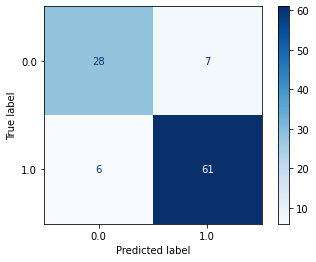

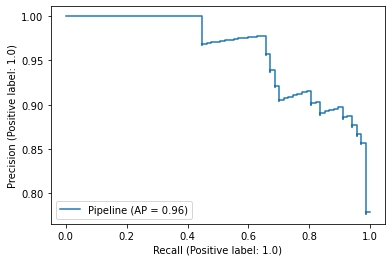

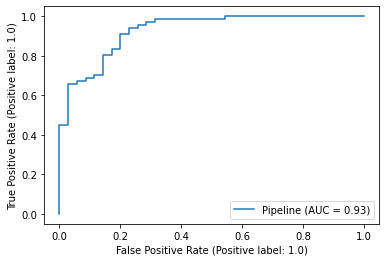

In [21]:
print_model_scores(svm_model, x_test, y_test)

plot_confusion_matrix(svm_model, x_test, y_test.ravel(), cmap='Blues')
plot_precision_recall_curve(svm_model, x_test, y_test.ravel())
plot_roc_curve(svm_model, x_test, y_test.ravel());

## Random Forest Classifier

In [15]:
rfc_pipeline = make_pipeline(
    StandardScaler(),
    RandomForestClassifier()
)

In [16]:
rfc_grid = GridSearchCV(rfc_pipeline, rfc_search_params, cv=10)
rfc_grid.fit(x_train, y_train.ravel())
rfc_model = rfc_grid.best_estimator_

In [17]:
pd.DataFrame(rfc_grid.cv_results_).sort_values(by='rank_test_score').head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_randomforestclassifier__max_depth,param_randomforestclassifier__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
73,0.219269,0.003810,0.014313,0.000922,None,140,"{'randomforestclassifier__max_depth': None, 'r...",0.878049,0.804878,0.97561,0.902439,0.850,0.825,0.850,0.875,0.900,0.900,0.876098,0.045596,1
72,0.205968,0.007996,0.013135,0.000444,None,130,"{'randomforestclassifier__max_depth': None, 'r...",0.878049,0.878049,0.97561,0.902439,0.800,0.825,0.850,0.850,0.875,0.875,0.870915,0.044835,2
62,0.049621,0.004115,0.003687,0.000080,None,30,"{'randomforestclassifier__max_depth': None, 'r...",0.804878,0.878049,0.97561,0.878049,0.850,0.850,0.875,0.825,0.900,0.850,0.868659,0.044335,3
50,0.171113,0.006409,0.011141,0.000406,8,110,"{'randomforestclassifier__max_depth': 8, 'rand...",0.853659,0.829268,0.97561,0.902439,0.875,0.825,0.825,0.850,0.875,0.850,0.866098,0.043451,4
53,0.232470,0.039042,0.016109,0.003965,8,140,"{'randomforestclassifier__max_depth': 8, 'rand...",0.878049,0.829268,0.97561,0.902439,0.800,0.825,0.825,0.850,0.900,0.875,0.866037,0.049038,5


Accuracy: 0.9019607843137255
Precision: 0.9402985074626866
Recall: 0.9130434782608695
F1-Score: 0.9264705882352942


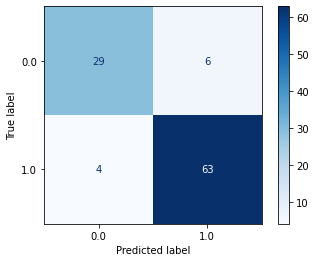

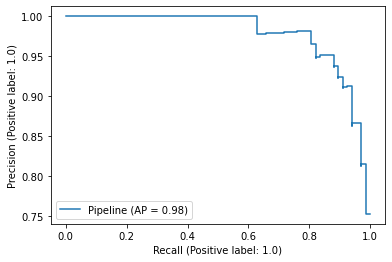

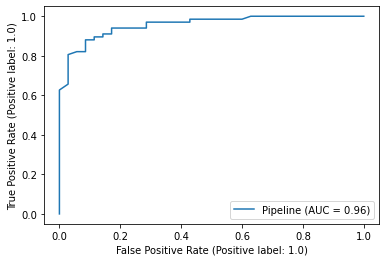

In [20]:
print_model_scores(rfc_model, x_test, y_test)

plot_confusion_matrix(rfc_model, x_test, y_test.ravel(), cmap='Blues')
plot_precision_recall_curve(rfc_model, x_test, y_test.ravel())
plot_roc_curve(rfc_model, x_test, y_test.ravel());